/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


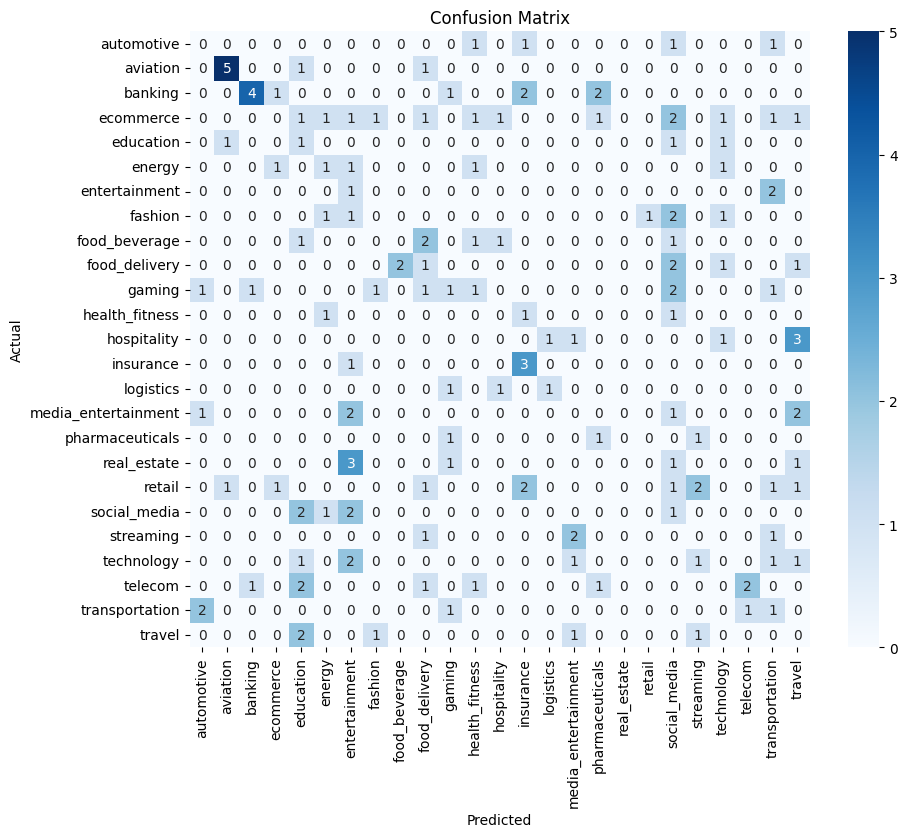

Classification Report:
                     precision    recall  f1-score   support

         automotive       0.00      0.00      0.00         4
           aviation       0.71      0.71      0.71         7
            banking       0.67      0.40      0.50        10
          ecommerce       0.00      0.00      0.00        13
          education       0.09      0.25      0.13         4
             energy       0.20      0.20      0.20         5
      entertainment       0.07      0.33      0.12         3
            fashion       0.00      0.00      0.00         6
      food_beverage       0.00      0.00      0.00         6
      food_delivery       0.11      0.14      0.12         7
             gaming       0.17      0.11      0.13         9
     health_fitness       0.00      0.00      0.00         3
        hospitality       0.00      0.00      0.00         6
          insurance       0.33      0.75      0.46         4
          logistics       0.50      0.33      0.40         3


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score for Clustering: 0.14043947292938302
Processing complete! Check saved files and visualizations.


In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import re
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report, silhouette_score
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Load dataset
df = pd.read_csv('/content/formatted_transactions.csv')

# Step 1: Data Preprocessing
def extract_company(desc):
    if ' - ' in desc:
        return desc.split(' - ')[1]
    return desc  # Return the whole description if the expected format is missing

df['Company'] = df['Transaction Description'].apply(extract_company)
df['Customer ID'] = np.random.randint(1, 501, size=len(df))

# Step 2: Industry Classification Setup
INDUSTRY_MAPPING = {
    'streaming': [
        'Netflix', 'Hotstar', 'Zee5', 'SonyLiv', 'Prime Video', 'Disney+', 'Hulu', 'HBO Max', 'YouTube Premium',
        'Apple TV+', 'Voot', 'AltBalaji', 'MX Player', 'JioCinema', 'Viu', 'Discovery+', 'Lionsgate Play',
        'Sun NXT', 'Aha', 'Hoichoi', 'Eros Now', 'ShemarooMe', 'Hungama Play', 'DocuBay', 'Mubi', 'Crunchyroll',
        'Funimation', 'Paramount+', 'Peacock', 'Tubi'
    ],
    'food_delivery': [
        'Zomato', 'Swiggy', 'Uber Eats', 'DoorDash', 'Grubhub', 'Postmates', 'Deliveroo', 'Just Eat', 'Foodpanda',
        'Glovo', 'Seamless', 'Caviar', 'SkipTheDishes', 'Menulog', 'Delivery Hero', 'Talabat', 'iFood', 'Rappi',
        'Gojek', 'GrabFood', 'Dunzo', 'Faasos', 'Box8', 'FreshMenu', 'Domino\'s', 'Pizza Hut', 'McDonald\'s',
        'Burger King', 'KFC', 'Subway'
    ],
    'ecommerce': [
        'Amazon', 'Flipkart', 'Myntra', 'Snapdeal', 'eBay', 'Walmart', 'Alibaba', 'Etsy', 'Shopify', 'Target',
        'Best Buy', 'Costco', 'JD.com', 'Rakuten', 'ShopClues', 'Paytm Mall', 'Tata Cliq', 'Nykaa', 'Meesho',
        'Ajio', 'FirstCry', 'BigBasket', 'Grofers', 'Reliance Digital', 'Croma', 'Vijay Sales', 'Lenskart',
        'Urban Ladder', 'Pepperfry', 'Zivame'
    ],
    'transportation': [
        'Ola', 'Uber', 'Rapido', 'Lyft', 'BlaBlaCar', 'Grab', 'Bolt', 'Didi', 'Gojek', 'Gett', 'Yandex.Taxi',
        'Careem', 'Curb', 'Via', 'Jugnoo', 'Meru Cabs', 'Easy Cabs', 'Savaari', 'Quick Ride', 'Shuttl', 'Zoomcar',
        'Revv', 'Drivezy', 'Avis', 'Hertz', 'Enterprise', 'Sixt', 'Budget', 'Zipcar', 'Turo'
    ],
    'health_fitness': [
        'Cult.fit', 'HealthifyMe', 'Fitbit', 'MyFitnessPal', 'Peloton', 'ClassPass', 'Gymshark', 'Zwift', 'Strava',
        'Headspace', 'Calm', 'Noom', 'Freeletics', 'Daily Burn', '8fit', 'Aaptiv', 'FitOn', 'Glo', 'Obé Fitness',
        'Beachbody', 'Fitness Blender', 'YogaGlo', 'Down Dog', 'Alo Moves', 'Centr', 'Fiit', 'Les Mills On Demand',
        'Nike Training Club', 'Adidas Training'
    ],
    'travel': [
        'MakeMyTrip', 'Yatra', 'ClearTrip', 'Booking.com', 'Expedia', 'Airbnb', 'TripAdvisor', 'Kayak', 'Agoda',
        'Skyscanner', 'Goibibo', 'Trivago', 'CheapOair', 'Priceline', 'Hotwire', 'Travelocity', 'Orbitz', 'Vrbo',
        'Hostelworld', 'Thomas Cook', 'SOTC', 'Cox & Kings', 'Kesari Tours', 'Club Mahindra', 'OYO', 'Treebo',
        'FabHotels', 'Lemon Tree Hotels', 'Taj Hotels', 'Marriott','RedBus'
    ],
    'entertainment': [
        'Spotify', 'BookMyShow', 'Netflix', 'Disney+', 'Hulu', 'YouTube', 'Twitch', 'TikTok', 'Instagram',
        'Facebook', 'Snapchat', 'Pinterest', 'Reddit', 'Tumblr', 'SoundCloud', 'Gaana', 'JioSaavn', 'Wynk Music',
        'Hungama', 'Spotify', 'Apple Music', 'Amazon Music', 'Pandora', 'Deezer', 'Tidal', 'Bandcamp', 'Mixcloud',
        'iHeartRadio', 'Audible', 'Podbean'
    ],
    'banking': [
        'ICICI', 'SBI', 'HDFC', 'Axis Bank', 'Kotak Mahindra', 'Citibank', 'HSBC', 'Standard Chartered',
        'Bank of America', 'Chase', 'Wells Fargo', 'Barclays', 'Deutsche Bank', 'BNP Paribas', 'Santander',
        'RBS', 'UBS', 'Credit Suisse', 'DBS', 'PNB', 'Canara Bank', 'Bank of Baroda', 'IDBI Bank', 'Yes Bank',
        'IndusInd Bank', 'RBL Bank', 'Federal Bank', 'Karur Vysya Bank', 'South Indian Bank', 'Union Bank'
    ],
    'telecom': [
        'Airtel', 'Jio', 'Vodafone', 'Verizon', 'AT&T', 'T-Mobile', 'Sprint', 'MTN', 'Orange', 'Telstra',
        'Deutsche Telekom', 'China Mobile', 'NTT', 'SoftBank', 'Telefonica', 'BT', 'Comcast', 'Reliance Jio',
        'BSNL', 'Idea', 'Tata Docomo', 'Aircel', 'MTS', 'Uninor', 'Videocon', 'Loop Mobile', 'Telenor',
        'Docomo Pacific', 'Digicel', 'Globe Telecom'
    ],
    'automotive': [
        'Tesla', 'Toyota', 'Ford', 'BMW', 'Mercedes-Benz', 'Honda', 'Hyundai', 'Maruti Suzuki', 'Tata Motors',
        'Volkswagen', 'Audi', 'Nissan', 'Chevrolet', 'Kia', 'Renault', 'Porsche', 'Jaguar', 'Land Rover',
        'Volvo', 'Fiat', 'Mazda', 'Subaru', 'Mitsubishi', 'Lexus', 'Skoda', 'Mahindra', 'Force Motors',
        'Ashok Leyland', 'Eicher Motors', 'Bajaj Auto'
    ],
    'technology': [
        'Apple', 'Microsoft', 'Google', 'Samsung', 'Intel', 'IBM', 'Oracle', 'Adobe', 'Sony', 'Dell', 'HP',
        'Lenovo', 'Asus', 'Acer', 'Toshiba', 'Canon', 'Nikon', 'Panasonic', 'LG', 'Huawei', 'Xiaomi', 'OnePlus',
        'Qualcomm', 'NVIDIA', 'AMD', 'Broadcom', 'Cisco', 'Ericsson', 'SAP', 'Infosys'
    ],
    'social_media': [
        'Facebook', 'Instagram', 'Twitter', 'LinkedIn', 'Snapchat', 'Pinterest', 'Reddit', 'TikTok', 'WhatsApp',
        'Telegram', 'Signal', 'WeChat', 'Line', 'Viber', 'Discord', 'Clubhouse', 'Tumblr', 'Quora', 'Medium',
        'Nextdoor', 'Meetup', 'Flickr', 'VK', 'Weibo', 'QQ', 'MySpace', 'Tagged', 'Badoo', 'Hi5', 'Friendster'
    ],
    'retail': [
        'Walmart', 'Target', 'Costco', 'Home Depot', 'IKEA', 'Best Buy', 'Tesco', 'Carrefour', 'Aldi', '7-Eleven',
        'Reliance Retail', 'Future Group', 'D-Mart', 'Spencer\'s', 'Big Bazaar', 'More Retail', 'Shoppers Stop',
        'Lifestyle', 'Pantaloons', 'Westside', 'Landmark Group', 'SPAR', 'HyperCity', 'Star Bazaar', 'Vishal Mega Mart',
        'Easyday', 'Nilgiris', 'Foodworld', 'Reliance Fresh'
    ],
    'education': [
        'Byju\'s', 'Unacademy', 'Coursera', 'Udemy', 'Khan Academy', 'Duolingo', 'edX', 'Vedantu', 'Toppr',
        'WhiteHat Jr', 'Simplilearn', 'UpGrad', 'Great Learning', 'Eruditus', 'Emeritus', 'Skillshare', 'Pluralsight',
        'LinkedIn Learning', 'MasterClass', 'Udacity', 'Codecademy', 'DataCamp', 'Coding Ninjas', 'Scaler Academy',
        'Camp K12', 'Extramarks', 'TopperLearning', 'Meritnation', 'Embibe', 'Adda247'
    ],
    'gaming': [
        'Steam', 'Epic Games', 'PlayStation', 'Xbox', 'Nintendo', 'EA Sports', 'Ubisoft', 'Blizzard', 'Riot Games',
        'Zynga', 'Activision', 'Take-Two Interactive', 'Square Enix', 'Capcom', 'Bandai Namco', 'Sega', 'Konami',
        'NetEase', 'Tencent Games', 'Garena', 'Gameloft', 'Supercell', 'King', 'Niantic', 'Roblox', 'Minecraft',
        'Fortnite', 'PUBG', 'Valorant', 'Call of Duty'
    ],
    'food_beverage': [
        'McDonald\'s', 'Starbucks', 'KFC', 'Domino\'s', 'Pizza Hut', 'Subway', 'Burger King', 'Coca-Cola',
        'Pepsi', 'Nestle', 'Unilever', 'P&G', 'Kraft Heinz', 'General Mills', 'Kellogg\'s', 'Mondelez', 'Danone',
        'Tyson Foods', 'Hershey\'s', 'Campbell Soup', 'Conagra Brands', 'JBS', 'Cargill', 'ADM', 'Tata Consumer',
        'Britannia', 'Amul', 'Parle', 'ITC Foods', 'Haldiram\'s'
    ],
    'pharmaceuticals': [
        'Pfizer', 'Johnson & Johnson', 'Novartis', 'Roche', 'Merck', 'GSK', 'Sanofi', 'Abbott', 'AstraZeneca',
        'Bayer', 'Novo Nordisk', 'Bristol-Myers Squibb', 'Eli Lilly', 'Amgen', 'Gilead Sciences', 'Biogen',
        'Teva', 'Takeda', 'Aurobindo Pharma', 'Sun Pharma', 'Dr. Reddy\'s', 'Cipla', 'Lupin', 'Zydus Cadila',
        'Torrent Pharma', 'Glenmark', 'Biocon', 'Divis Labs', 'Alkem Labs', 'Ipca Labs'
    ],
    'insurance': [
        'LIC', 'ICICI Prudential', 'HDFC Life', 'SBI Life', 'Max Life', 'Bajaj Allianz', 'New India Assurance',
        'United India', 'National Insurance', 'Reliance General', 'Tata AIG', 'Chola MS', 'Star Health', 'Care Health',
        'ManipalCigna', 'Aditya Birla Health', 'Kotak Life', 'Aviva Life', 'Exide Life', 'Bharti AXA', 'Future Generali',
        'Royal Sundaram', 'Shriram Life', 'Canara HSBC', 'Pramerica Life', 'IDBI Federal', 'Edelweiss Tokio',
        'Aegon Life', 'IndiaFirst Life', 'PNB MetLife'
    ],
    'logistics': [
        'FedEx', 'UPS', 'DHL', 'Blue Dart', 'DTDC', 'Amazon Logistics', 'Delhivery', 'Ecom Express', 'XpressBees',
        'Shadowfax', 'Gati', 'SafeExpress', 'Aramex', 'TNT Express', 'SF Express', 'YTO Express', 'ZTO Express',
        'STO Express', 'Best Express', 'Yunda Express', 'Kerry Logistics', 'Nippon Express', 'DB Schenker',
        'Kuehne + Nagel', 'CEVA Logistics', 'Agility', 'XPO Logistics', 'DSV', 'Panalpina', 'Geodis'
    ],
    'real_estate': [
        'PropTiger', 'MagicBricks', '99acres', 'Housing.com', 'Square Yards', 'CommonFloor', 'Makaan.com', 'Zillow',
        'Realtor.com', 'Redfin', 'Trulia', 'Opendoor', 'Compass', 'WeWork', 'Knight Frank', 'CBRE', 'JLL', 'Colliers',
        'Savills', 'Cushman & Wakefield', 'RE/MAX', 'Century 21', 'Coldwell Banker', 'ERA Real Estate', 'Sotheby\'s',
        'Christie\'s International', 'Engel & Völkers', 'Luxury Portfolio', 'Douglas Elliman', 'Corcoran Group'
    ],
    'energy': [
        'Reliance Industries', 'BP', 'Shell', 'ExxonMobil', 'Chevron', 'Total', 'Indian Oil', 'HPCL', 'BPCL',
        'NTPC', 'ONGC', 'GAIL', 'Adani Power', 'Tata Power', 'NLC India', 'NHPC', 'SJVN', 'Power Grid Corporation',
        'Siemens', 'GE Power', 'ABB', 'Schneider Electric', 'Vestas', 'Suzlon', 'First Solar', 'SunPower',
        'Canadian Solar', 'Trina Solar', 'JinkoSolar', 'Enphase Energy'
    ],
    'aviation': [
        'Indigo', 'Air India', 'SpiceJet', 'Vistara', 'Emirates', 'Qatar Airways', 'Singapore Airlines', 'Delta',
        'American Airlines', 'Lufthansa', 'British Airways', 'Air France', 'KLM', 'Cathay Pacific', 'Qantas',
        'Turkish Airlines', 'Etihad Airways', 'ANA', 'Japan Airlines', 'Korean Air', 'Thai Airways', 'Malaysia Airlines',
        'AirAsia', 'Ryanair', 'EasyJet', 'Southwest Airlines', 'JetBlue', 'Alaska Airlines', 'United Airlines',
        'Air Canada'
    ],
    'hospitality': [
        'Marriott', 'Hilton', 'Hyatt', 'Taj Hotels', 'Oberoi', 'Airbnb', 'Booking.com', 'Expedia', 'Trivago',
        'Agoda', 'InterContinental', 'Accor', 'Wyndham', 'Choice Hotels', 'Radisson', 'Shangri-La', 'Four Seasons',
        'Mandarin Oriental', 'Rosewood', 'Fairmont', 'Ritz-Carlton', 'St. Regis', 'W Hotels', 'Westin', 'Sheraton',
        'Holiday Inn', 'Crowne Plaza', 'Novotel', 'ibis', 'Best Western'
    ],
    'fashion': [
        'Zara', 'H&M', 'Nike', 'Adidas', 'Puma', 'Levi\'s', 'Gucci', 'Louis Vuitton', 'Prada', 'Uniqlo',
        'Forever 21', 'Gap', 'Tommy Hilfiger', 'Calvin Klein', 'Ralph Lauren', 'Burberry', 'Chanel', 'Dior',
        'Versace', 'Armani', 'Dolce & Gabbana', 'Fendi', 'Balenciaga', 'Givenchy', 'Yves Saint Laurent',
        'Michael Kors', 'Coach', 'Kate Spade', 'Tory Burch', 'Jimmy Choo'
    ],
    'media_entertainment': [
        'Disney', 'Warner Bros', 'Sony Pictures', 'Netflix', 'Amazon Prime Video', 'HBO', 'BBC', 'CNN', 'Fox',
        'ViacomCBS', 'Comcast', 'NBCUniversal', 'Paramount', 'Discovery', 'AMC Networks', 'Lionsgate', 'MGM',
        'A24', 'STX Entertainment', 'Legendary Entertainment', 'DreamWorks', 'Pixar', 'Marvel Studios',
        'DC Films', 'Universal Pictures', '20th Century Studios', 'Miramax', 'Focus Features', 'A&E Networks',
        'Showtime'
    ]
}

# Step 3: Deep Learning Model Preparation
all_companies = [(company, industry)
                 for industry, companies in INDUSTRY_MAPPING.items()
                 for company in companies]
train_df = pd.DataFrame(all_companies, columns=['Company', 'Industry'])

# Tokenize company names
tokenizer = Tokenizer(num_words=1000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['Company'])
sequences = tokenizer.texts_to_matrix(train_df['Company'], mode='tfidf')

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(train_df['Industry'])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)

# Build and train DL model
model = Sequential([
    Dense(128, activation='relu', input_shape=(1000,)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), verbose=0)

# Step 4: Evaluate the Classification Model
# Predict on test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix.png')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# Step 5: Enhanced Company Classifier
class CompanyClassifier:
    def __init__(self):
        self.model = model
        self.tokenizer = tokenizer
        self.label_encoder = label_encoder
        self.keyword_rules = {
    'streaming': [
        'stream', 'flix', 'tv', 'video', 'movie', 'series', 'show', 'watch', 'entertainment', 'on demand',
        'premium', 'subscription', 'channel', 'episode', 'season', 'documentary', 'anime', 'cartoon',
        'live', 'broadcast', 'vod', 'ott', 'platform', 'library', 'catalog', 'originals', 'replay', 'binge'
    ],
    'food_delivery': [
        'food', 'eats', 'restaurant', 'meal', 'delivery', 'takeout', 'takeaway', 'cuisine', 'dine', 'dish',
        'menu', 'order', 'hungry', 'snack', 'beverage', 'drink', 'catering', 'groceries', 'kitchen', 'chef',
        'recipe', 'fast food', 'pizza', 'burger', 'sushi', 'dessert', 'bakery', 'coffee', 'tea', 'juice'
    ],
    'ecommerce': [
        'shop', 'store', 'buy', 'sell', 'market', 'mall', 'retail', 'online', 'deal', 'offer', 'discount',
        'sale', 'product', 'item', 'cart', 'checkout', 'payment', 'shipping', 'delivery', 'return', 'refund',
        'fashion', 'electronics', 'appliance', 'grocery', 'furniture', 'beauty', 'accessory', 'gadget', 'brand'
    ],
    'transportation': [
        'ride', 'taxi', 'cab', 'car', 'bike', 'scooter', 'auto', 'share', 'pool', 'commute', 'travel', 'move',
        'transit', 'route', 'fare', 'book', 'driver', 'passenger', 'pickup', 'drop', 'distance', 'mileage',
        'fuel', 'trip', 'journey', 'express', 'local', 'outstation', 'rental', 'lease'
    ],
    'health_fitness': [
        'health', 'fitness', 'gym', 'workout', 'exercise', 'yoga', 'pilates', 'meditation', 'wellness', 'diet',
        'nutrition', 'weight', 'loss', 'gain', 'muscle', 'strength', 'cardio', 'trainer', 'coach', 'class',
        'session', 'studio', 'club', 'active', 'fit', 'shape', 'recovery', 'therapy', 'massage', 'sport'
    ],
    'travel': [
        'travel', 'trip', 'tour', 'vacation', 'holiday', 'flight', 'hotel', 'resort', 'stay', 'booking',
        'ticket', 'destination', 'itinerary', 'sightseeing', 'adventure', 'explore', 'journey', 'cruise',
        'package', 'tourist', 'visa', 'passport', 'airport', 'airline', 'luggage', 'backpack', 'safari', 'camp'
    ],
    'entertainment': [
        'entertainment', 'music', 'movie', 'concert', 'theater', 'show', 'performance', 'festival', 'event',
        'ticket', 'booking', 'live', 'stream', 'comedy', 'drama', 'art', 'culture', 'gaming', 'sports',
        'amusement', 'park', 'arcade', 'casino', 'club', 'party', 'dance', 'karaoke', 'standup', 'magic'
    ],
    'banking': [
        'bank', 'financial', 'credit', 'loan', 'mortgage', 'savings', 'account', 'deposit', 'withdrawal',
        'transfer', 'investment', 'wealth', 'insurance', 'policy', 'premium', 'claim', 'card', 'debit',
        'credit', 'atm', 'branch', 'interest', 'rate', 'fund', 'stock', 'bond', 'mutual', 'portfolio', 'advisor'
    ],
    'telecom': [
        'telecom', 'mobile', 'phone', 'sim', 'data', 'internet', 'broadband', 'wifi', 'network', 'signal',
        'call', 'sms', 'message', 'roaming', 'plan', 'package', 'recharge', 'balance', 'tariff', 'connection',
        'service', 'provider', 'operator', '5g', '4g', 'lte', 'voip', 'fiber', 'satellite', 'communication'
    ],
    'automotive': [
        'auto', 'car', 'bike', 'vehicle', 'motor', 'engine', 'tire', 'fuel', 'petrol', 'diesel', 'electric',
        'hybrid', 'charging', 'service', 'repair', 'spare', 'part', 'accessory', 'dealership', 'showroom',
        'insurance', 'finance', 'lease', 'rental', 'test drive', 'mileage', 'performance', 'safety', 'luxury', 'suv'
    ],
    'technology': [
        'tech', 'software', 'hardware', 'computer', 'laptop', 'desktop', 'server', 'cloud', 'data', 'ai',
        'machine learning', 'iot', 'blockchain', 'cyber', 'security', 'network', 'coding', 'programming',
        'developer', 'engineer', 'app', 'website', 'platform', 'solution', 'service', 'support', 'maintenance',
        'upgrade', 'innovation', 'digital'
    ],
    'social_media': [
        'social', 'media', 'network', 'connect', 'share', 'post', 'like', 'comment', 'follow', 'friend',
        'message', 'chat', 'group', 'community', 'profile', 'feed', 'story', 'reel', 'trend', 'viral',
        'influencer', 'creator', 'content', 'platform', 'app', 'engagement', 'follower', 'hashtag', 'mention', 'tag'
    ],
    'retail': [
        'retail', 'shop', 'store', 'mall', 'outlet', 'supermarket', 'hypermarket', 'grocery', 'fashion',
        'electronics', 'appliance', 'furniture', 'beauty', 'cosmetic', 'accessory', 'jewelry', 'watch',
        'footwear', 'clothing', 'brand', 'discount', 'sale', 'offer', 'deal', 'promotion', 'loyalty', 'reward',
        'membership', 'customer'
    ],
    'education': [
        'education', 'learn', 'study', 'course', 'class', 'school', 'college', 'university', 'institute',
        'academy', 'training', 'coaching', 'tutor', 'teacher', 'student', 'exam', 'test', 'certificate',
        'degree', 'diploma', 'online', 'offline', 'skill', 'knowledge', 'workshop', 'seminar', 'webinar',
        'lecture', 'assignment', 'project'
    ],
    'gaming': [
        'game', 'gaming', 'play', 'console', 'pc', 'mobile', 'online', 'offline', 'multiplayer', 'singleplayer',
        'arcade', 'action', 'adventure', 'puzzle', 'strategy', 'rpg', 'simulation', 'sports', 'racing', 'shooter',
        'vr', 'ar', 'esports', 'tournament', 'leaderboard', 'score', 'level', 'character', 'quest', 'loot'
    ],
    'food_beverage': [
        'food', 'beverage', 'drink', 'snack', 'meal', 'restaurant', 'cafe', 'bakery', 'bar', 'pub', 'brewery',
        'coffee', 'tea', 'juice', 'soda', 'alcohol', 'wine', 'beer', 'spirit', 'cocktail', 'mocktail', 'dessert',
        'sweet', 'chocolate', 'ice cream', 'pastry', 'cake', 'bread', 'pizza', 'burger'
    ],
    'pharmaceuticals': [
        'pharma', 'medicine', 'drug', 'pill', 'tablet', 'capsule', 'syrup', 'injection', 'vaccine', 'health',
        'care', 'treatment', 'therapy', 'clinic', 'hospital', 'doctor', 'nurse', 'patient', 'prescription',
        'generic', 'branded', 'otc', 'rx', 'research', 'lab', 'clinical', 'trial', 'biotech', 'life science'
    ],
    'insurance': [
        'insurance', 'policy', 'premium', 'claim', 'cover', 'protection', 'health', 'life', 'vehicle', 'home',
        'travel', 'accident', 'medical', 'term', 'endowment', 'ulip', 'pension', 'annuity', 'renewal', 'agent',
        'broker', 'advisor', 'risk', 'benefit', 'compensation', 'liability', 'indemnity', 'assurance', 'coverage', 'plan'
    ],
    'logistics': [
        'logistics', 'delivery', 'courier', 'parcel', 'package', 'shipment', 'cargo', 'freight', 'transport',
        'warehouse', 'storage', 'supply', 'chain', 'distribution', 'fulfillment', 'order', 'tracking', 'dispatch',
        'pickup', 'drop', 'express', 'standard', 'international', 'domestic', 'customs', 'clearance', 'inventory',
        'stock', 'route'
    ],
    'real_estate': [
        'real estate', 'property', 'house', 'apartment', 'flat', 'villa', 'land', 'plot', 'commercial',
        'residential', 'rent', 'lease', 'buy', 'sell', 'invest', 'broker', 'agent', 'developer', 'builder',
        'construction', 'project', 'location', 'amenity', 'furnished', 'unfurnished', 'sale', 'purchase',
        'mortgage', 'loan', 'valuation'
    ],
    'energy': [
        'energy', 'power', 'electricity', 'solar', 'wind', 'hydro', 'thermal', 'nuclear', 'renewable',
        'non-renewable', 'oil', 'gas', 'petroleum', 'coal', 'refinery', 'generation', 'transmission',
        'distribution', 'grid', 'utility', 'meter', 'billing', 'tariff', 'subsidy', 'sustainability',
        'green', 'carbon', 'emission', 'climate'
    ],
    'aviation': [
        'aviation', 'airline', 'flight', 'airport', 'pilot', 'cabin', 'crew', 'ticket', 'booking', 'boarding',
        'pass', 'luggage', 'baggage', 'check-in', 'security', 'immigration', 'customs', 'terminal', 'gate',
        'runway', 'hangar', 'cargo', 'freight', 'charter', 'private', 'jet', 'turbine', 'propeller', 'aircraft'
    ],
    'hospitality': [
        'hospitality', 'hotel', 'resort', 'stay', 'accommodation', 'room', 'suite', 'lobby', 'reception',
        'check-in', 'check-out', 'amenity', 'spa', 'pool', 'gym', 'restaurant', 'bar', 'cafe', 'buffet',
        'breakfast', 'lunch', 'dinner', 'banquet', 'event', 'conference', 'meeting', 'wedding', 'party', 'service'
    ],
    'fashion': [
        'fashion', 'clothing', 'apparel', 'wear', 'outfit', 'dress', 'shirt', 'pant', 'jean', 'skirt', 'jacket',
        'coat', 'suit', 'tie', 'accessory', 'jewelry', 'watch', 'bag', 'shoe', 'footwear', 'designer', 'brand',
        'luxury', 'trend', 'style', 'collection', 'season', 'launch', 'sale', 'discount'
    ],
    'media_entertainment': [
        'media', 'entertainment', 'news', 'tv', 'radio', 'print', 'digital', 'publishing', 'advertising',
        'marketing', 'pr', 'public relations', 'journalism', 'reporting', 'anchor', 'reporter', 'editor',
        'content', 'article', 'blog', 'vlog', 'podcast', 'stream', 'broadcast', 'live', 'event', 'festival',
        'award', 'celebrity'
    ]
}
        # Use INDUSTRY_MAPPING directly without modification
        self.mapping = INDUSTRY_MAPPING

    def classify_company(self, company):
        # Try DL prediction first
        sequence = self.tokenizer.texts_to_matrix([company], mode='tfidf')
        pred = self.model.predict(sequence, verbose=0)
        confidence = np.max(pred)

        if confidence > 0.7:
            return self.label_encoder.inverse_transform([np.argmax(pred)])[0]
        else:
            return self._rule_based_classification(company)

    def _rule_based_classification(self, company):
        for industry, companies in self.mapping.items():
            if company in companies:
                return industry

        lower_company = company.lower()
        for industry, keywords in self.keyword_rules.items():
            if any(kw in lower_company for kw in keywords):
                return industry

        # If no match, classify as "Other"
        return 'Other'

# Classify companies
classifier = CompanyClassifier()
df['Industry'] = df['Company'].apply(classifier.classify_company)

# Step 6: Customer Segmentation
customer_spending = df.groupby(['Customer ID', 'Industry'])['Amount'].sum().unstack(fill_value=0)
spending_percentages = customer_spending.div(customer_spending.sum(axis=1), axis=0)
customer_spending['Primary Segment'] = spending_percentages.idxmax(axis=1)
customer_spending['Segment Confidence'] = spending_percentages.max(axis=1)
customer_spending['Total Spending'] = customer_spending.select_dtypes(include=[np.number]).sum(axis=1)
customer_spending['Transaction Count'] = df.groupby('Customer ID').size()

# Step 7: Evaluate Clustering (Silhouette Score)
# Use spending percentages for clustering
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
customer_spending['Cluster'] = kmeans.fit_predict(spending_percentages)

# Silhouette Score
silhouette_avg = silhouette_score(spending_percentages, customer_spending['Cluster'])
print(f"Silhouette Score for Clustering: {silhouette_avg}")

# Step 8: Industry Analysis
industry_analysis = df.groupby('Industry').agg(
    Total_Revenue=('Amount', 'sum'),
    Average_Transaction=('Amount', 'mean'),
    Unique_Customers=('Customer ID', pd.Series.nunique)
).sort_values('Total_Revenue', ascending=False)

# Step 9: Visualization Functions
def plot_industry_analysis(industry_analysis):
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 2, 1)
    industry_analysis['Total_Revenue'].sort_values().plot(kind='barh')
    plt.title('Total Revenue by Industry')

    plt.subplot(2, 2, 2)
    industry_analysis['Average_Transaction'].sort_values().plot(kind='barh')
    plt.title('Average Transaction Value')

    plt.subplot(2, 2, 3)
    industry_analysis['Unique_Customers'].sort_values().plot(kind='barh')
    plt.title('Unique Customers')
    plt.tight_layout()
    plt.savefig('industry_analysis.png')
    plt.show()

def plot_customer_segments(customer_spending):
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    customer_spending['Primary Segment'].value_counts().plot(kind='pie', autopct='%1.1f%%')
    plt.title('Segment Distribution')

    plt.subplot(1, 2, 2)
    sns.histplot(customer_spending['Segment Confidence'], bins=10)
    plt.title('Confidence Distribution')
    plt.tight_layout()
    plt.savefig('customer_segments.png')
    plt.show()

def plot_spending_patterns(spending_percentages):
    plt.figure(figsize=(12, 8))
    sns.heatmap(spending_percentages.corr(), annot=True, cmap='coolwarm')
    plt.title('Industry Spending Correlations')
    plt.savefig('spending_correlations.png')
    plt.show()

# Step 10: Save Results
df.to_csv('processed_transactions.csv', index=False)
customer_spending.to_csv('customer_segments.csv')

print("Processing complete! Check saved files and visualizations.")

In [ ]:
# After creating clusters, add this analysis
cluster_characteristics = customer_spending.groupby('Cluster').agg({
    'Total Spending': ['mean', 'median', 'std'],
    'Transaction Count': ['mean', 'median'],
    'Segment Confidence': 'mean'
}).reset_index()

# Get top industries for each cluster
cluster_profiles = spending_percentages.join(customer_spending['Cluster']).groupby('Cluster').mean()

# Display results
print("\nCluster Characteristics:")
print(cluster_characteristics)

print("\nCluster Spending Profiles:")
print(cluster_profiles)


Cluster Characteristics:
Industry Cluster Total Spending                               \
                           mean         median           std   
0              0  153493.737183  154991.368911  32961.840065   
1              1  150727.010101  145121.142373  32336.643916   
2              2  151470.036293  147404.275495  32191.048257   
3              3  145911.749000  147238.734135  31600.693390   

Industry Transaction Count        Segment Confidence  
                      mean median               mean  
0                30.440299   30.0           0.269497  
1                29.873950   30.0           0.236824  
2                30.381443   30.0           0.287736  
3                29.460000   30.0           0.324867  

Cluster Spending Profiles:
            Other  ecommerce  entertainment   fashion  food_delivery  \
Cluster                                                                
0        0.044959   0.183657       0.043824  0.043170       0.080648   
1        0.0497

In [ ]:
df.head()

,Transaction ID,Date,Amount,Transaction Description,Company,Customer ID,Industry
0,834a7bcb-fcb7-4746-8a8e-396631d84281,15-02-2025,6325.11,Credit Card - Ola - Order##fihhg-ICICI,Ola,141,transportation
1,e28ac142-b5b6-41ab-b05a-2c51b02e07d5,16-09-2024,468.38,UPI - TataCliq - Order##nioDr-ICICI,TataCliq,250,Other
2,15c536f4-29b2-4ad1-a541-362f20f3b56e,02-11-2024,3632.53,Cash - RedBus - Order##tWjlg-Axis Bank,RedBus,160,travel
3,e417b507-6256-49d9-88b8-a968dc86d842,12-02-2025,8696.02,UPI - Zee5 - Order##yqGBV-Axis Bank,Zee5,250,streaming
4,fc5ade61-a07b-4f5c-8910-533af0a583e6,09-11-2024,9492.04,Net Banking - Rapido - Order##Llaos-SBI,Rapido,296,transportation


In [ ]:
def plot_industry_analysis(industry_analysis):
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 2, 1)
    industry_analysis['Total_Revenue'].sort_values().plot(kind='barh')
    plt.title('Total Revenue by Industry')

    plt.subplot(2, 2, 2)
    industry_analysis['Average_Transaction'].sort_values().plot(kind='barh')
    plt.title('Average Transaction Value')

    plt.subplot(2, 2, 3)
    industry_analysis['Unique_Customers'].sort_values().plot(kind='barh')
    plt.title('Unique Customers')
    plt.tight_layout()
    plt.savefig('industry_analysis.png')
    plt.show()

def plot_customer_segments(customer_spending):
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    customer_spending['Primary Segment'].value_counts().plot(kind='pie', autopct='%1.1f%%')
    plt.title('Segment Distribution')

    plt.subplot(1, 2, 2)
    sns.histplot(customer_spending['Segment Confidence'], bins=10)
    plt.title('Confidence Distribution')
    plt.tight_layout()
    plt.savefig('customer_segments.png')
    plt.show()

def plot_spending_patterns(spending_percentages):
    plt.figure(figsize=(12, 8))
    sns.heatmap(spending_percentages.corr(), annot=True, cmap='coolwarm')
    plt.title('Industry Spending Correlations')
    plt.savefig('/content/spending_correlations.png')
    plt.show()

In [ ]:
%matplotlib inline

In [ ]:
import matplotlib
matplotlib.use('TkAgg')  # or 'Qt5Agg', 'Agg', etc., depending on your environment

ImportError: Cannot load backend 'TkAgg' which requires the 'tk' interactive framework, as 'headless' is currently running

In [ ]:
print(industry_analysis)
print(customer_spending)
print(spending_percentages)

                Total_Revenue  Average_Transaction  Unique_Customers
Industry                                                            
ecommerce         16711568.52          5047.287381               500
travel            13058026.81          5080.944284               497
streaming         13036430.54          4956.817696               496
transportation     9936818.83          4968.409415               498
health_fitness     6619849.08          5080.467444               465
food_delivery      6162878.64          4946.130530               458
fashion            3300498.24          4860.822150               362
Other              3161600.90          4955.487304               366
entertainment      3096218.36          4969.852905               349
Industry        Other  ecommerce  entertainment   fashion  food_delivery  \
Customer ID                                                                
1             6373.13   30819.75        6591.99  19443.36       24565.06   
2            

In [ ]:
import matplotlib.pyplot as plt

def plot_industry_analysis(industry_analysis):
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 2, 1)
    industry_analysis['Total_Revenue'].sort_values().plot(kind='barh')
    plt.title('Total Revenue by Industry')

    plt.subplot(2, 2, 2)
    industry_analysis['Average_Transaction'].sort_values().plot(kind='barh')
    plt.title('Average Transaction Value')

    plt.subplot(2, 2, 3)
    industry_analysis['Unique_Customers'].sort_values().plot(kind='barh')
    plt.title('Unique Customers')
    plt.tight_layout()
    plt.savefig('/content/industry_analysis.png')
    # No need for plt.show() in Colab

In [ ]:
plt.show()

In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
from tensorflow.keras.optimizers import Adam

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the data
def encode_examples(texts, labels, max_length=64):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return np.array(input_ids), np.array(attention_masks), np.array(labels)

# Encode the dataset
input_ids, attention_masks, labels = encode_examples(train_df['Company'], labels)

# Load pre-trained BERT model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Compile the model
model.compile(optimizer=Adam(learning_rate=2e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit([input_ids, attention_masks], labels, epochs=3, batch_size=16, validation_split=0.2)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ValueError: Could not interpret optimizer identifier: <keras.src.optimizers.adam.Adam object at 0x7ca8401b8e90>